# 小鼠社交行为分类实验

## 实验说明
- **S1 Behavior**: 3分类 (base, social, nonsocial)
- **S2 Aggression**: 7分类 (lateralthreat, keepdown, clinch, uprightposture, freezing, bite, chase)

## 数据来源
- DLC CSV文件: DeepLabCut多动物追踪结果
- 标注文件: Caltech Behavior Annotator标注

## 1. 环境设置

In [9]:
# 安装依赖
import subprocess
import sys

packages = ['lightgbm', 'xgboost', 'hmmlearn', 'seaborn', 'scikit-learn', 'torch']

for package in packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed")

✓ lightgbm already installed
✓ xgboost already installed
✓ hmmlearn already installed
✓ seaborn already installed
Installing scikit-learn...
✓ scikit-learn installed
✓ torch already installed


In [10]:
# 导入库
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# 添加src路径
sys.path.insert(0, '../src')

from label_parser import AnnotationParser, parse_all_annotations, get_class_names
from feature_extraction import DLCFeatureExtractor, get_feature_names
from data_loader import prepare_dataset, create_data_loaders, create_numpy_splits
from models import get_pytorch_model, get_sklearn_model, compute_class_weights

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

# 设备
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"PyTorch: {torch.__version__}")
print(f"Device: {DEVICE}")
print("\n✓ Environment setup complete!")

PyTorch: 2.9.1+cpu
Device: cpu

✓ Environment setup complete!


## 2. 实验配置

In [12]:
# ============================================================================
# 实验配置 - 修改这里切换实验
# ============================================================================

EXPERIMENT = "aggression"  # 选项: "behavior" (3类) 或 "aggression" (7类)

# 数据路径 (Kaggle上修改为实际路径)
# Kaggle路径示例:
# CSV_FOLDER = "/kaggle/input/mouse-behavior/dlc_csv"
# ANNOT_FOLDER = "/kaggle/input/mouse-behavior/annotations"

# 本地路径示例:
CSV_FOLDER = "../data/dlc_csv"           # DLC CSV文件夹
ANNOT_FOLDER = "../data/annotations"     # 标注文件夹
CACHE_DIR = "../data/cache"              # 缓存目录
OUTPUT_DIR = "../outputs"                # 输出目录

# 训练参数
N_RUNS = 5           # 运行次数
N_EPOCHS = 200       # 训练轮数
BATCH_SIZE = 256     # 批量大小

print(f"{'='*60}")
print(f"EXPERIMENT: {EXPERIMENT.upper()}")
if EXPERIMENT == "behavior":
    print("  4-class: aggression, social, nonsocial")
else:
    print("  7-class: lateralthreat, keepdown, clinch, uprightposture, freezing, bite, chase")
print(f"{'='*60}")

EXPERIMENT: AGGRESSION
  7-class: lateralthreat, keepdown, clinch, uprightposture, freezing, bite, chase


## 3. 数据加载与预处理

In [13]:
# 准备数据集 - 直接得到3分类 (排除base已在label_parser中处理)
X, y, feature_names, class_info = prepare_dataset(
    CSV_FOLDER, 
    ANNOT_FOLDER, 
    experiment=EXPERIMENT,
    cache_dir=CACHE_DIR
)

# 不需要再过滤！label_parser 已经排除了 base
n_features = X.shape[1]
n_classes = class_info['n_classes']
class_names = class_info['class_names']

# 计算各类别样本数
class_counts = [np.sum(y == i) for i in range(n_classes)]

print(f"\n✓ Dataset loaded!")
print(f"  Features: {n_features}")
print(f"  Samples: {X.shape[0]:,}")
print(f"  Classes: {n_classes}")
for i, name in enumerate(class_names):
    print(f"    {i}: {name} ({class_counts[i]:,} samples)")

Step 1: Extracting features from DLC files...
Loading cached features from ..\data\cache\features.pkl
Total features shape: (832913, 36)

Step 2: Parsing annotations for aggression experiment...
  Video 10: 140/14956 valid frames (0.9%)
  Video 11: 115/14778 valid frames (0.8%)
  Video 12: 2198/12987 valid frames (16.9%)
  Video 13: 313/13185 valid frames (2.4%)
  Video 14: 480/15183 valid frames (3.2%)
  Video 15: 0/13800 valid frames (0.0%)
  Video 16: 19/14700 valid frames (0.1%)
  Video 17: 0/13983 valid frames (0.0%)
  Video 18: 61/13974 valid frames (0.4%)
  Video 19: 0/14144 valid frames (0.0%)
  Video 1: 3764/14733 valid frames (25.5%)
  Video 20: 811/13680 valid frames (5.9%)
  Video 21: 0/14567 valid frames (0.0%)
  Video 22: 172/13945 valid frames (1.2%)
  Video 23: 236/14099 valid frames (1.7%)
  Video 24: 4117/13384 valid frames (30.8%)
  Video 25: 2286/14255 valid frames (16.0%)
  Video 26: 24/14064 valid frames (0.2%)
  Video 27: 2672/14397 valid frames (18.6%)
  Video 2

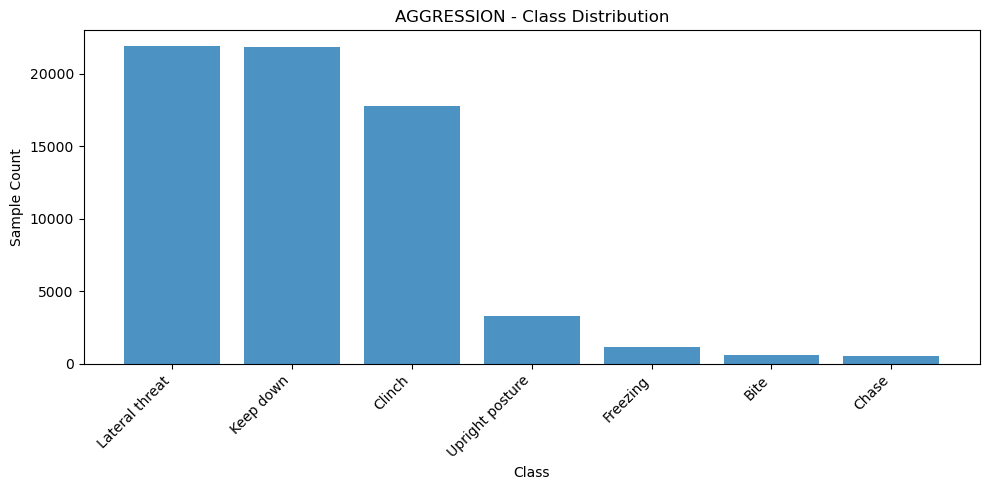

In [14]:
# 可视化类别分布
plt.figure(figsize=(10, 5))
plt.bar(range(n_classes), class_info['class_counts'], alpha=0.8)
plt.xticks(range(n_classes), class_names, rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.title(f'{EXPERIMENT.upper()} - Class Distribution')
plt.tight_layout()
plt.show()

## 4. 模型训练

In [15]:
def train_pytorch_model(model, train_loader, val_loader, n_epochs, device, class_weights=None):
    """训练PyTorch模型"""
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_f1 = 0
    best_state = None
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validate
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                preds = model(features).argmax(dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.numpy())
        
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        scheduler.step(1 - val_f1)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = model.state_dict().copy()
        
        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs} | Loss: {train_loss/len(train_loader):.4f} | Val F1: {val_f1:.4f}")
    
    # 恢复最佳模型
    if best_state:
        model.load_state_dict(best_state)
    
    return model, best_f1


def evaluate_model(model, test_loader, device):
    """评估模型"""
    model.eval()
    test_preds, test_labels = [], []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            preds = model(features).argmax(dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_labels.extend(labels.numpy())
    
    acc = accuracy_score(test_labels, test_preds)
    f1_weighted = f1_score(test_labels, test_preds, average='weighted')
    f1_macro = f1_score(test_labels, test_preds, average='macro')
    
    return {
        'accuracy': acc,
        'weighted_f1': f1_weighted,
        'macro_f1': f1_macro,
        'y_true': test_labels,
        'y_pred': test_preds
    }

print("✓ Training functions defined")

✓ Training functions defined


In [16]:
# 运行多次实验
def run_experiments(model_type, n_runs=5):
    """运行多次实验"""
    results = {'accuracy': [], 'weighted_f1': [], 'macro_f1': []}
    
    print(f"\n{'='*60}")
    print(f"Running {model_type.upper()} ({n_runs} runs)")
    print(f"{'='*60}")
    
    for run in range(n_runs):
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # 创建数据加载器
        train_loader, val_loader, test_loader, scaler = create_data_loaders(
            X, y, batch_size=BATCH_SIZE, random_state=seed
        )
        
        # 计算类别权重
        y_train = np.concatenate([batch[1].numpy() for batch in train_loader])
        class_weights = compute_class_weights(y_train, n_classes)
        
        # 创建模型
        model = get_pytorch_model(model_type, n_features, n_classes).to(DEVICE)
        
        # 训练
        model, best_f1 = train_pytorch_model(
            model, train_loader, val_loader, 
            n_epochs=N_EPOCHS, device=DEVICE, 
            class_weights=class_weights
        )
        
        # 评估
        metrics = evaluate_model(model, test_loader, DEVICE)
        
        results['accuracy'].append(metrics['accuracy'])
        results['weighted_f1'].append(metrics['weighted_f1'])
        results['macro_f1'].append(metrics['macro_f1'])
        
        print(f"Run {run+1}: Acc={metrics['accuracy']:.4f}, F1={metrics['weighted_f1']:.4f}")
    
    # 统计
    stats = {}
    for key in results:
        stats[key] = {
            'mean': np.mean(results[key]),
            'std': np.std(results[key], ddof=1)
        }
    
    print(f"\n{model_type.upper()} Summary:")
    print(f"  Accuracy: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
    print(f"  Weighted F1: {stats['weighted_f1']['mean']:.4f} ± {stats['weighted_f1']['std']:.4f}")
    
    return stats

print("✓ Experiment function defined")

✓ Experiment function defined


In [8]:
# 运行所有模型
all_results = {}

# PyTorch模型
for model_type in ['mlp', 'lstm', 'cnn']:
    try:
        all_results[model_type.upper()] = run_experiments(model_type, n_runs=N_RUNS)
    except Exception as e:
        print(f"Error in {model_type}: {e}")


Running MLP (5 runs)
Data split: Train=487902, Val=104550, Test=104551
  Epoch 20/200 | Loss: 0.7476 | Val F1: 0.6751
  Epoch 40/200 | Loss: 0.7334 | Val F1: 0.6882
  Epoch 60/200 | Loss: 0.7170 | Val F1: 0.7037
  Epoch 80/200 | Loss: 0.7067 | Val F1: 0.7105
  Epoch 100/200 | Loss: 0.6900 | Val F1: 0.7242
  Epoch 120/200 | Loss: 0.6805 | Val F1: 0.7269
  Epoch 140/200 | Loss: 0.6753 | Val F1: 0.7306
  Epoch 160/200 | Loss: 0.6696 | Val F1: 0.7335
  Epoch 180/200 | Loss: 0.6677 | Val F1: 0.7340
  Epoch 200/200 | Loss: 0.6679 | Val F1: 0.7336
Run 1: Acc=0.7151, F1=0.7345
Data split: Train=487902, Val=104550, Test=104551
  Epoch 20/200 | Loss: 0.7458 | Val F1: 0.6737
  Epoch 40/200 | Loss: 0.7312 | Val F1: 0.6807
  Epoch 60/200 | Loss: 0.7280 | Val F1: 0.7011
  Epoch 80/200 | Loss: 0.7249 | Val F1: 0.7090
  Epoch 100/200 | Loss: 0.7024 | Val F1: 0.7172


KeyboardInterrupt: 

In [20]:
# sklearn模型
# 在 "安装依赖" cell 之前添加这个 cell

# 修复 Windows 上 joblib 的 wmic 错误
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # 设置为你的 CPU 核心数

import lightgbm as lgb
import xgboost as xgb

def run_sklearn_experiments(model_name, n_runs=5):
    """运行sklearn模型实验"""
    results = {'accuracy': [], 'weighted_f1': [], 'macro_f1': []}
    
    print(f"\n{'='*60}")
    print(f"Running {model_name.upper()} ({n_runs} runs)")
    print(f"{'='*60}")
    
    for run in range(n_runs):
        seed = 42 + run
        
        # 创建数据分割
        splits, scaler = create_numpy_splits(X, y, random_state=seed)
        
        if model_name.lower() == 'lightgbm':
            # LightGBM
            params = {
                'objective': 'multiclass',
                'num_class': n_classes,
                'metric': 'multi_logloss',
                'verbose': -1
            }
            train_data = lgb.Dataset(splits['X_train'], label=splits['y_train'])
            model = lgb.train(params, train_data, num_boost_round=100)
            y_pred = model.predict(splits['X_test']).argmax(axis=1)
            
        elif model_name.lower() == 'xgboost':
            # XGBoost
            params = {
                'objective': 'multi:softmax',
                'num_class': n_classes,
                'verbosity': 0
            }
            dtrain = xgb.DMatrix(splits['X_train'], label=splits['y_train'])
            dtest = xgb.DMatrix(splits['X_test'])
            model = xgb.train(params, dtrain, num_boost_round=100)
            y_pred = model.predict(dtest).astype(int)
            
        else:
            # RandomForest, SVM
            model = get_sklearn_model(model_name, n_classes, random_state=seed)
            model.fit(splits['X_train'], splits['y_train'])
            y_pred = model.predict(splits['X_test'])
        
        acc = accuracy_score(splits['y_test'], y_pred)
        f1_w = f1_score(splits['y_test'], y_pred, average='weighted')
        f1_m = f1_score(splits['y_test'], y_pred, average='macro')
        
        results['accuracy'].append(acc)
        results['weighted_f1'].append(f1_w)
        results['macro_f1'].append(f1_m)
        
        print(f"Run {run+1}: Acc={acc:.4f}, F1={f1_w:.4f}")
    
    stats = {key: {'mean': np.mean(v), 'std': np.std(v, ddof=1)} for key, v in results.items()}
    
    print(f"\n{model_name.upper()} Summary:")
    print(f"  Accuracy: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
    
    return stats

# 运行sklearn模型
for model_name in ['LightGBM']:
    try:
        all_results[model_name] = run_sklearn_experiments(model_name, n_runs=N_RUNS)
    except Exception as e:
        print(f"Error in {model_name}: {e}")


Running LIGHTGBM (5 runs)
Run 1: Acc=0.7411, F1=0.7379
Run 2: Acc=0.7474, F1=0.7480
Run 3: Acc=0.7479, F1=0.7488
Run 4: Acc=0.7407, F1=0.7412
Run 5: Acc=0.7407, F1=0.7413

LIGHTGBM Summary:
  Accuracy: 0.7436 ± 0.0038


## 5. 结果可视化

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/aggression_comparison.png'

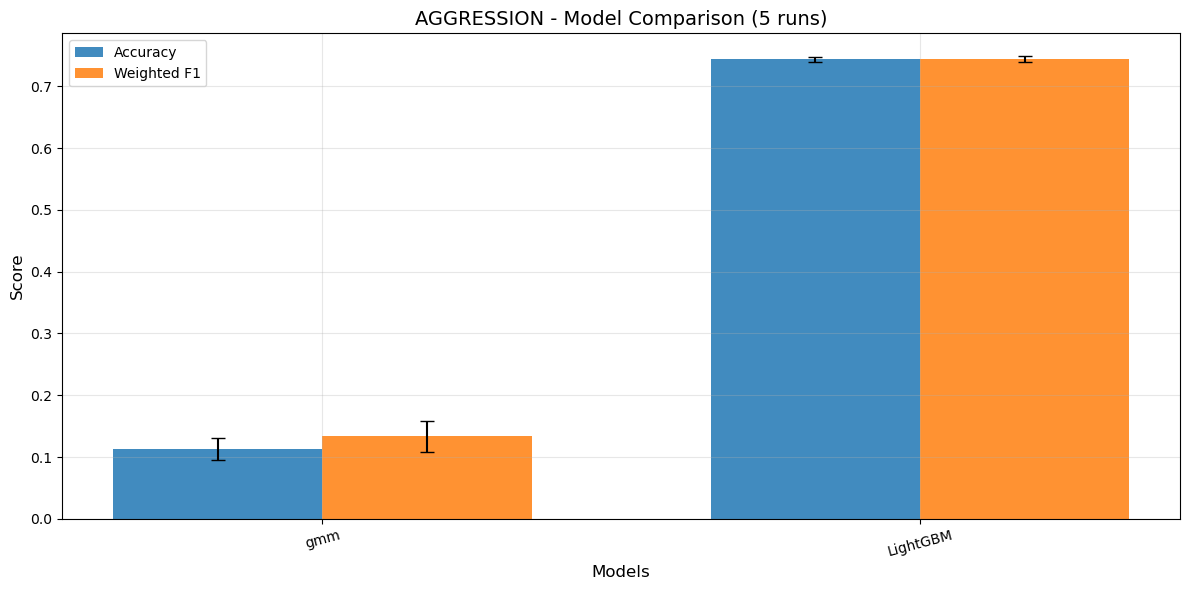

In [21]:
# 性能对比图
if all_results:
    models = list(all_results.keys())
    metrics = ['accuracy', 'weighted_f1']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.35
    
    for i, metric in enumerate(metrics):
        means = [all_results[m][metric]['mean'] for m in models]
        stds = [all_results[m][metric]['std'] for m in models]
        ax.bar(x + i*width, means, width, label=metric.replace('_', ' ').title(),
               yerr=stds, capsize=5, alpha=0.85)
    
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'{EXPERIMENT.upper()} - Model Comparison ({N_RUNS} runs)', fontsize=14)
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(models, rotation=15)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/{EXPERIMENT}_comparison.png', dpi=300)
    plt.show()
    
    print("✓ Comparison plot saved!")

In [ ]:
# 结果汇总表
print("\n" + "="*80)
print(f"RESULTS SUMMARY - {EXPERIMENT.upper()} ({n_classes}-Class)")
print("="*80)

header = f"{'Model':<15} {'Accuracy':<20} {'Weighted F1':<20} {'Macro F1':<20}"
print(header)
print("-" * len(header))

for model in all_results:
    acc = f"{all_results[model]['accuracy']['mean']:.4f}±{all_results[model]['accuracy']['std']:.4f}"
    f1w = f"{all_results[model]['weighted_f1']['mean']:.4f}±{all_results[model]['weighted_f1']['std']:.4f}"
    f1m = f"{all_results[model]['macro_f1']['mean']:.4f}±{all_results[model]['macro_f1']['std']:.4f}"
    print(f"{model:<15} {acc:<20} {f1w:<20} {f1m:<20}")

print("\n✓ Experiments completed!")

## 6. 实验总结

### 类别映射

#### S1: Behavior (3分类)
| Class | Name |
|-------|------|
| 0 | Base |
| 1 | Social |
| 2 | Nonsocial |

#### S2: Aggression (7分类)
| Class | Name |
|-------|------|
| 0 | Lateral threat |
| 1 | Keep down |
| 2 | Clinch |
| 3 | Upright posture |
| 4 | Freezing |
| 5 | Bite |
| 6 | Chase |

### 特征说明
- **速度特征** (4): top1_speed, top2_speed, body1_speed, body2_speed
- **距离特征** (4): top_distance, body_distance, top1_tail2_distance, top2_tail1_distance
- **角度特征** (2): angle_top1_tail1, angle_top2_tail2
- **坐标特征** (12): 两只小鼠各3个身体部位的x,y坐标
- **交互特征** (4): relative_angle, speed_ratio, approach_speed, body_speed_diff